<div style=" border-bottom: 8px solid #e3f56c; overflow: hidden; border-radius: 10px; height: 60px; width: 100%; display: flex;">
  <div style="height: 100%; width: 100%; background-color: #3800BB; float: left; text-align: center; display: flex; justify-content: left; align-items: center; font-size: 40px; ">
    <b><span style="color: #FFFFFF; padding: 20px 20px;">XGBoost</span></b>
  </div>
</div>

<div class="alert" style="background-color: #FEDAD5; border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">
  <h5 style="font-size: 16px; margin-bottom: 10px;">
    <strong> Contents </strong>
  </h5>
<hr>
  <p><font size="3" face="Arial" font-size="large">
  <ul type="square">

  <li> `DMatrix` for data preprocessing  </li>
  <li> Two main types of model training in XGBoost  </li>
  <li> Important model hyperparameters  </li>
  <li> Hyperparameter tuning  </li>
  <li> `LearningRateScheduler`  </li>
  <li> Custom metrics from `scikit-learn`  </li>
  <li> Conclusions and summary  </li>
  
  </ul>
  </font></p>

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`XGBoost` was developed as a research project at the University of Washington. Tianqi Chen and Carlos Guestrin presented their work at the SIGKDD conference in 2016, making a big impact in the machine learning world. Since its release, this algorithm has not only dominated Kaggle competitions but has also powered numerous industrial applications.

</div>

<div class="alert alert-info">

### **Some key features:**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* Rich set of regularization parameters (`lambda` / `gamma` / `alpha`)
* Considered one of the fastest and least resource-intensive boosting algorithms (though debatable)
* Built-in handling of missing values and categorical features (via `one-hot encoding`) (`enable_categorical = True` / `df[cat_col].astype('category')`)
* Native support for metrics from **scikit-learn** as custom metrics

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* Native support for `Dask` and `Spark`
* Compatible with popular cloud platforms and supports distributed training across clusters or multiple machines
* Supports most major programming languages
* Integrates well with other frameworks and services (**Optuna**, **Weights & Biases**, etc.)

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

**Boosting Implementation Details (see the diagram):**

* **Parallelization:** In `XGBoost`, tree construction is parallelized. This is made possible by rearranging the nested loops used to compute split points: the outer loop iterates over tree leaves, and the inner one over features. Swapping the loops allows efficient parallel computation. Initialization occurs during data loading, followed by sorting with parallel threads, which significantly speeds up training.

* **Tree Pruning (`gamma`):** Unlike traditional GBMs that use negative loss reduction as a split-stopping criterion, `XGBoost` employs `max_depth` and performs *post-pruning* based on a minimum loss reduction (`gamma`). This approach improves computational efficiency.

* **Hardware Optimization:** The algorithm is engineered to maximize hardware utilization by creating internal buffers per thread to store gradient statistics.

* **Regularization:** To prevent overfitting, `XGBoost` applies both L1 (LASSO) and L2 (Ridge) regularization.

* **Handling Missing Values:** `XGBoost` handles sparse data gracefully, learning how to assign missing values based on the direction that minimizes loss.

* **Cross-Validation:** The algorithm includes a built-in method for performing cross-validation during training.

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

From the user’s perspective, `XGBoost` is quite similar to `LightGBM`: it uses a `booster` object, has a dedicated **sklearn API**, supports `dart`, `callbacks`, `scheduler`, etc. However, there are some key differences worth exploring.

</div>

<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

!pip install xgboost

</div>

In [1]:
import xgboost as xgb

import numpy as np
import pandas as pd

import warnings; warnings.filterwarnings("ignore")
from classes import Paths

In [2]:
paths = Paths()
path = paths.quickstart_train
df = pd.read_csv(path)
print(df.shape)
df.head(10)

(2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.10,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.00,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.10,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.10,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.10,203.462289,-14.260456,174,171
5,b12101843B,Skoda Rapid,economy,petrol,2.36,2013,42176,2018,48.99,engine_ignition,4.351782,1.085589e+07,0.10,180.886289,-18.221832,174,173
6,Q-9368117S,Nissan Qashqai,standart,petrol,5.32,2012,24611,2014,54.72,engine_overheat,4.392126,8.343280e+06,0.10,174.984786,12.321364,174,167
7,O-2124190y,Tesla Model 3,premium,electro,3.90,2017,116872,2019,50.40,gear_stick,4.712356,9.793288e+06,0.10,95.890736,-8.939366,174,139
8,h16895544p,Kia Sportage,standart,petrol,3.50,2014,56384,2017,33.59,gear_stick,4.507759,1.644405e+07,0.32,101.798615,-1.164690,174,170
9,K77009462l,Smart ForFour,economy,petrol,4.56,2013,41309,2018,39.04,gear_stick,4.376839,6.975742e+06,0.10,125.254983,3.769684,174,173


In [3]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

X = df.drop(drop_cols, axis=1)
y = df['target_reg']

<div class="alert alert-warning">

### **`DMatrix` for Data Preprocessing**

</div>

<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `CatBoost` -> `Pool`
* `LightGBM` -> `Dataset`
* `XGBoost` -> `DMatrix`

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

The `DMatrix` class is designed to create a data structure optimized for use in `XGBoost`. It's built for efficient memory usage and fast training. It supports various data formats and includes a handy `missing` parameter to handle missing values on the fly.<br>

Let's go over its key parameters, especially those not typically found in other boosting libraries:

* `data` – training data
* `label` – target values
* `nthread` – number of parallel threads to use when loading data (`-1` uses all available threads)
* `missing` (default: `np.nan`) – specify the value to treat as missing
* `enable_categorical` – automatically detects categorical features if the DataFrame columns are pre-converted to `category` type.<br>
* As with `LightGBM`, string-based categorical features must be converted to integers beforehand (i.e., apply label encoding).<br>

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* It also provides a useful method `save_binary(fname, silent=True)` – this allows saving the dataset in a binary format, reducing memory usage and speeding up future experiments. <br>

* ⚠️ Notably, there is a special class called `QuantileDMatrix`, which creates a quantile-based dataset directly from the data source. This helps conserve memory by avoiding intermediate data storage. It introduces a few extra parameters:
    * `max_bin` – controls the number of bins for quantization (must match the model's `max_bin` parameter)
    * `ref` – used when creating a validation dataset; refers to a training `QuantileDMatrix` to reuse quantile information and prevent data leakage.

</div>

In [4]:
from sklearn.model_selection import train_test_split

# let's change cat features to 'category' type
for col in cat_cols:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     nthread=-1,
                     enable_categorical=True,)

dtest = xgb.DMatrix(X_test,
                    y_test,
                    nthread=-1,
                    enable_categorical=True)

<div class="alert alert-warning">

### **Just like in `LightGBM`, there are two main ways to train a model in `XGBoost`:**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* **Standalone method: `train()`**
* **Classic sklearn-style API with `fit()` and `predict()`**

<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

There are also `dask` APIs (`dask.train()`) and a `spark` API (`spark.SparkXGBRegressor`, for example).<br>
Additionally, separate classes are available for training `Random Forests` (e.g., `xgboost.XGBRFRegressor`).

</div>

</div>

<div class="alert alert-warning">

#### **Method 1: With `train()`, you provide a dictionary of parameters, datasets, and number of boosting rounds.**

</div>

In [6]:
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',  # or 'gpu_hist' for acceleration
    'seed': 42,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=30,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    early_stopping_rounds=10,
                    verbose_eval=5)

[0]	dtrain-rmse:14.51967	dtest-rmse:15.73818
[5]	dtrain-rmse:9.49716	dtest-rmse:12.65256
[10]	dtrain-rmse:7.94051	dtest-rmse:12.71816
[15]	dtrain-rmse:7.23939	dtest-rmse:12.75195
[18]	dtrain-rmse:6.55863	dtest-rmse:12.88637


<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

In the `predict` method of all previously mentioned boosting frameworks, there is a parameter that controls how many trees are used for prediction. This can be useful when there's no validation dataset or for checking data leaks — by submitting predictions to the leaderboard with fewer or more trees than the best iteration. In `XGBoost`, this parameter is called `iteration_range`.

</div>

In [7]:
# inference
from sklearn.metrics import mean_squared_error

y_pred = booster.predict(dtest,
                         iteration_range=(0, booster.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

12.621295288019933

<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`iteration_range` option can be used to simulate `early_stopping_rounds` for trained boosters in `dart` modes, where there is no early stopping.

</div>

<div class="alert" style="background-color: #FEDAD5; border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

**How to SAVE and LOAD model?**

</div>

In [8]:
# saving the model
booster.save_model('xgb_0001.json')

In [9]:
# Load model
bst = xgb.Booster({'nthread': 4})
bst.load_model('xgb_0001.json')

In [10]:
y_pred = bst.predict(dtest)
mean_squared_error(y_test, y_pred) ** 0.5

12.88636633819062

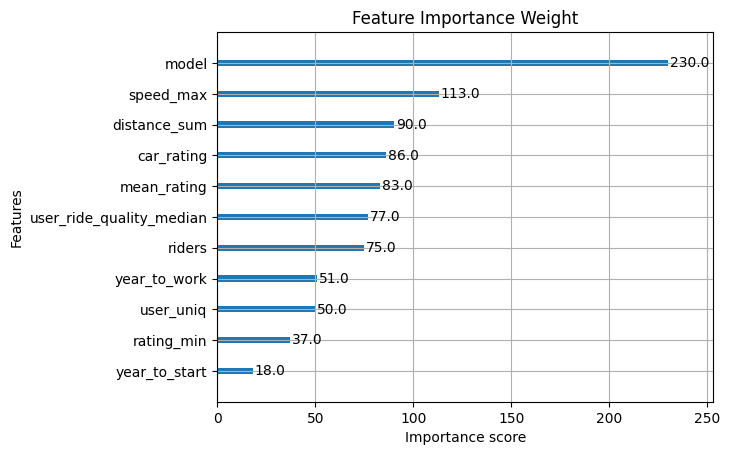

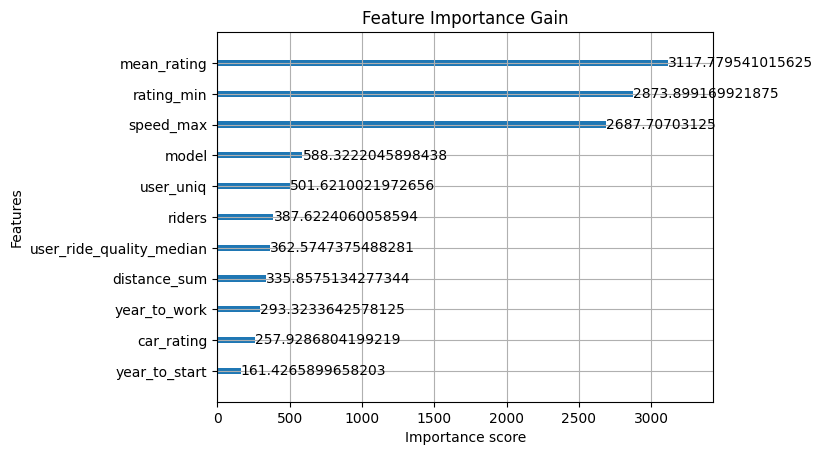

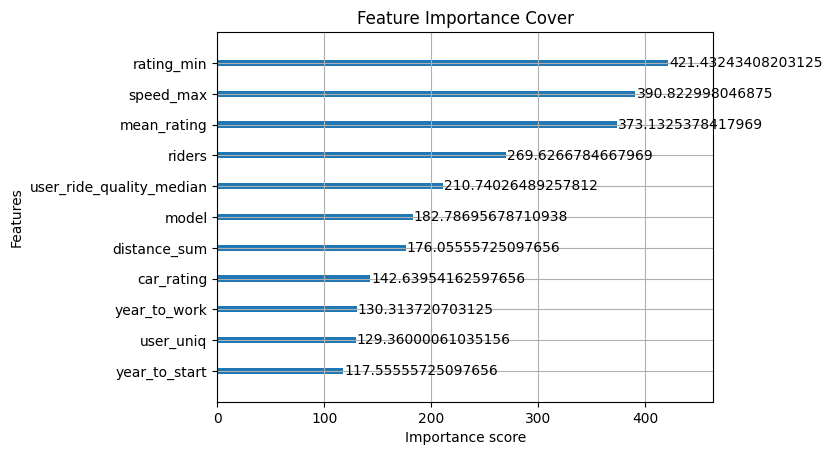

In [11]:
# ”weight” is the number of times a feature appears in a tree
# ”gain” is the average gain of splits which use the feature
# ”cover” is the average coverage of splits which use the feature where overage is defined as the number of samples affected by the split

xgb.plot_importance(bst, title='Feature Importance Weight')
xgb.plot_importance(bst, importance_type='gain', title='Feature Importance Gain')
xgb.plot_importance(bst, importance_type='cover', title='Feature Importance Cover');

<div class="alert alert-warning">

#### **Method 2: Using `Scikit-Learn` API.**
</div>

In [12]:
reg = xgb.XGBRegressor(tree_method="hist",
                       enable_categorical=True,
                       use_rmm = True)

# fit() does not accept DMatrix
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# reg.set_param({"predictor": "gpu_predictor"}) # cpu_predictor
y_pred = reg.predict(X_test)

In [14]:
print(mean_squared_error(y_test, y_pred) ** 0.5)

# unlike LightGBM, you don't need to get the booster object before saving
reg.save_model("xgb_regressor.json")
reg.load_model("xgb_regressor.json")
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred) ** 0.5)

13.404463678084706
13.404463678084706


<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

It is more convenient if we set up the `K-Fold` validation ourselves.

</div>

<div class="alert alert-warning">

### **Important model [Hyperparameters](https://xgboost.readthedocs.io/en/stable/parameter.html)**

</div>

<div class="alert alert-warning">

#### **Main Parameters**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `booster` (default=`gbtree`)
  * `gbtree` - gradient boosting over decision trees
  * `dart` - gradient boosting with dropout (already familiar from `LightGBM`)
  * `gblinear` - regularized gradient boosting with L1 and L2 regularization (only works with `DMatrix`) — something new

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `verbosity` (default=1) - controls the level of messages printed during training: 0 (silent), 1 (warning), 2 (info), 3 (debug)
* `verbose_eval` (default=1, in sklearn API: `verbose`) - frequency of training logs output (1 — every iteration, 5 — every 5 iterations, etc.)
* `nthread` (default=-1 meaning max available, in sklearn API: `n_jobs`) - number of CPU cores used during training
* ⚠️ `use_rmm` - whether to use RAPIDS Memory Manager (RMM) for GPU memory allocation. Only applicable if `XGBoost` is built with RMM support. Acceptable values: True or False.

</div>

<div class="alert alert-warning">

#### **What about `GPU`?**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">
    
* `tree_method` (default='auto') - `'hist'` or `'gpu_hist'`, whether to train on CPU or GPU
  * `auto`: heuristic selection of the fastest method.
  * `exact`: Exact greedy algorithm — evaluates all possible split candidates (for small datasets).
  * `approx`: Approximate greedy algorithm — uses quantile sketching and gradient histograms (for large datasets).
  * `hist`: Faster histogram-optimized approximate greedy algorithm (better for large datasets).
  * `gpu_hist`: GPU implementation of the `hist` algorithm.

</div>

<div class="alert alert-warning">

#### **Booster Parameters**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `eta` (default=0.3, aka: `learning_rate`) - the learning rate or shrinkage step size.
* `max_depth` (default=6) - maximum depth of a tree. Deeper trees create more complex models and may overfit.
* `num_boosting_rounds` (default=100, in sklearn API: `n_estimators`) - number of boosting iterations (trees).

</div>

<div class="alert alert-warning">

### **Regularization Parameters (`alpha`/`lambda`/`gamma`)**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `lambda` (default=1, alias: `reg_lambda`) and `alpha` (default=0, alias: `reg_alpha`) - responsible for L2 and L1 regularization respectively. The higher the value, the more conservative (less prone to overfitting but might miss relevant information) the model becomes. Recommended values are typically between `0–1000`.
* `gamma` (default=0, aka: `min_split_loss`) - the minimum loss reduction required to make a further partition on a leaf node. Higher `gamma` values lead to more conservative models.
</div>

<div class="alert alert-danger">

#### **More Regularization**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `min_child_weight` (default=1) - if a partition results in a leaf node with a sum of instance weights smaller than `min_child_weight`, the partition is discarded. Higher values make the model more conservative.
* `subsample` (default=1) - the fraction of the training samples used for growing each tree. (e.g., 0.5 uses half the data). It refreshes every boosting iteration.
* `colsample_bytree`, `colsample_bylevel`, `colsample_bynode` (default=1) - family of parameters to subsample columns at different levels of the tree building process.
* `max_bin` (default=256) - maximum number of bins used for splitting features. Increasing it can make binning more precise but slows training.
</div>

<div class="alert alert-warning">

### **`DART` Booster Parameters**

</div>

<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`dart` — Mode with `dropout`, similar to dropout in neural networks.

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `rate_drop` (default=0.0) - dropout rate: fraction of previous trees to drop during boosting.
* `one_drop` (default=0) (0 or 1) - if 1, at least one tree is always dropped during dropout.
* `skip_drop` (default=0.0) - probability of skipping dropout during a boosting iteration (takes precedence over `rate_drop` and `one_drop`).

⚠️ **Important note:** Using `predict()` with a `DART` booster.  
If the booster is of type `DART`, `predict()` performs dropout, meaning only a subset of trees is used.  
Thus, predictions on non-training data may be incorrect unless you specify `iteration_range`.

**Example:**  
`preds = bst.predict(dtest, iteration_range=(0, num_round))`

🍏 **Fun fact:** In `LightGBM`, there is a parameter `xgboost_dart_mode` (True/False), suggesting a difference in DART implementations.  
**set this to true if you want to use xgboost-style dart mode**
</div>

<div class="alert alert-warning">

### **Training Parameters**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`objective` (`default=reg:squarederror`) — defines the loss function, determining the task:

* `reg:squaredlogerror` — squared log error
* `reg:logistic` — logistic regression
* `reg:absoluteerror` — absolute error
* `binary:logistic` — binary classification (outputs probabilities)
* `binary:logitraw` — binary classification (outputs raw scores)
* `multi:softmax` — multiclass classification
* and many others

`eval_metric` (defaults depending on `objective`) — evaluation function:
* `rmse`, `mae`, `mape` — for regression
* `logloss`, `mlogloss` — for classification
* `auc`, and others

`seed` (default=0) — sets the random seed.

</div>

<div class="alert alert-warning">

### **`LearningRateScheduler` — changing `lr` during training**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* XGBoost provides a dedicated class `xgboost.callback.LearningRateScheduler(learning_rates)`, which accepts a list of `eta` values equal to the number of boosting iterations.
* Similar to schedulers used in neural network training, we can smoothly reduce the `learning rate`, which speeds up training without sacrificing model accuracy.
* You can experiment with various scheduling patterns, warm-up periods, etc.

</div>

**Let’s see an example:**

In [15]:
# Create a list of learning rates using np.linspace
iters = 30  
learning_rates = np.linspace(0.3, 0.005, iters).tolist()  # learning rate will gradually decrease from 0.3 to 0.005  
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'seed': 42,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=iters,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    callbacks=[scheduler],  # <------ ✅
                    early_stopping_rounds=10,
                    verbose_eval=5)

y_pred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))  
mean_squared_error(y_test, y_pred) ** 0.5

[0]	dtrain-rmse:14.51967	dtest-rmse:15.73818
[5]	dtrain-rmse:9.71674	dtest-rmse:12.75821
[10]	dtrain-rmse:8.30419	dtest-rmse:12.73867
[15]	dtrain-rmse:7.73567	dtest-rmse:12.72774
[16]	dtrain-rmse:7.69031	dtest-rmse:12.73391


12.682673723125248

<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #5ad197; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

We can observe that the model's accuracy increased, and `early stopping` did not trigger — meaning the accuracy could continue to improve if training is extended.

</div>

<div class="alert alert-warning">

### **Custom metric from `sklearn`**

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

In `XGBoost`, out-of-the-box support is provided for metrics from `scikit-learn` as `eval_metric`, which is undoubtedly very convenient: simply import and use them for model training.

As with other boosting algorithms, custom metrics and losses are supported — the implementation mechanism is quite similar everywhere.

</div>

In [16]:
from sklearn.metrics import mean_poisson_deviance
print("In {} version of xgboost early_stopping_rounds is in XGBRegressor class. Not in .fit()-method".format(xgb.__version__))

reg = xgb.XGBRegressor(tree_method="hist",
                       eval_metric = mean_poisson_deviance, # <------ ✅
                       enable_categorical=True,
                       n_estimators=30, n_jobs=-1,
                       early_stopping_rounds=10  # Moved here from fit()
)
reg.fit(X_train, y_train, 
        eval_set=[(X_test, y_test)],
        # early_stopping_rounds=10,
        verbose=3)

In 3.0.0 version of xgboost early_stopping_rounds is in XGBRegressor class. Not in .fit()-method
[0]	validation_0-rmse:15.73818	validation_0-mean_poisson_deviance:4.83291
[3]	validation_0-rmse:13.04271	validation_0-mean_poisson_deviance:3.25132
[6]	validation_0-rmse:12.64687	validation_0-mean_poisson_deviance:3.07632
[9]	validation_0-rmse:12.65160	validation_0-mean_poisson_deviance:3.07671
[12]	validation_0-rmse:12.67780	validation_0-mean_poisson_deviance:3.08867
[15]	validation_0-rmse:12.75195	validation_0-mean_poisson_deviance:3.13961
[17]	validation_0-rmse:12.83047	validation_0-mean_poisson_deviance:3.17346


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True,
             eval_metric=<function mean_poisson_deviance at 0x1697c7f60>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30, n_jobs=-1,
             num_parallel_tree=None, ...)

In [17]:
y_pred = reg.predict(X_test, iteration_range=(0, reg.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

12.621295288019933

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

We can see that `early_stopping` worked with the metric from `sklearn`. 

In `XGBoost` (as in `LightGBM`), there is the option to customize `early stopping` to specify which metric to use for stopping training. [Official tutorial.](https://xgboost.readthedocs.io/en/stable/python/callbacks.html)

</div>

<div class="alert alert-success">

### **Conclusions and Summary** 
</div>

<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #5ad197; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `XGBoost` is very similar to `LightGBM`.
* Due to differences in the implementation of boosting algorithms, it can be a good idea to include it in an ensemble. You never know what will perform best.
* Pros: built-in handling of missing values, convenient integration with `scikit-learn`, integration into many ML frameworks and cloud services.
* Relatively easy to accelerate on `GPU`.
* It continues to develop and will remain a strong baseline for a long time.

</div>

<div class="alert alert-success">

### **Useful Resources** 
</div>

<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #5ad197; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* [Documentation with hyperparameter overview](https://xgboost.readthedocs.io/en/stable/parameter.html)
* [L1, L2 regularization in boosting, using XGBoost as an example](https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0)
* [Familiar article on XGBoost and Catboost](https://habr.com/ru/companies/ods/articles/645887/)
</div>